# Toy MC for the ATLAS High Granularity Timing Detector

#### This program is a toy Monte Carlo used to simulate noise and signal on the ATLAS High Granularity Detector, and study the uncertainties in the luminosity that can be achieve with the help of this detector.
<ul>
<li>Written by Ruben Pozzi for the KTH ATLAS Group</li>
<li>Supervisor: Christian Ohm - christian.ohm@cern.ch</li>
<li>Contact: rubenp@kth.se, rubenpozzi97@gmail.com</li>
</ul>

## Background and aim

#### This program simulates the detector response with given fixed physical parameters such as the $\mu$ value, number of bunch crossings and the most probable value (mpv) of the peak voltage signal function.
<ul>
<li>In this simulation, both the "true" noise and signal and the estimated values of the noise and signal activated channels on the detector are simulated. The difference (or deviation) between these two is the main object of study of this simulation. This deviation from the true values is representative of the luminosity that the detector can achieve, and the uncertainties of these values are also studied.</li>
<li> Assumptions: when a charged particle passes through a sensor, it induces a voltage that follows a Landau distribution, while the noise on the detector is assumed to be a normally distributed around 0mV with standard deviation of 5mV. Finally, because of radiation damage, the SNR of the sensors worsens, and this is reflected by a lower mpv of the peak voltage of the Landau distribution of the signal. </li>
<li>A threshold is set to distinguish between the noise-activated channels and the signal-activated ones.</li>
</ul>

### Import stuff

In [1]:
import ROOT
from ROOT import TCanvas, TGraph, gROOT
import numpy as np
import time
import matplotlib.pyplot as plt
import time 
from array import array
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator

Welcome to JupyROOT 6.22/08


### Constants

In [2]:
nr_of_channels = int(3.6 * 1e6) #number of channels on the HGTD
channels_per_module = int(15*30) #number of channels in each module of the detector
total_modules = int(nr_of_channels/channels_per_module) #number of modules
global_counter = 0 #global counter used for the pseudorandomgenerator in the next section

## Noise Generator Class:
<ul>
<li>This class takes in the parameters threshold and channel count (proportional to the number of interactions $\mu$ per bunch crossing) and calculates the mean number of channels activated by noise <code>mean</code> by calculating the probability mass that a part of the Gaussian distribution will be above the set threshold, and multiplies it with the total number of channels.</li>
<li>The class has a function generate, which calculates a variation of the mean number of noise activated channels by drawing from a Poisson distribution with <code>mean</code> as parameter, and calculates how many of them are triggered during the small time window of $3.125ns$ (the <i>true</i> value, <code>narrow_exact</code>) by drawing from a uniform distribution $(0,1)$ for each number of noise activated channel and seeing how many are in the small time window. For example, with a large window of 25ns, it would check how many values drawn from the uniform distribution are lower than 0.125 {=3.125/25 = 0.125}. </li>
<li>Finally, it <i>estimates</i> the number of triggered channels in the small window <code>estimate</code> by determining the number of channels triggered in one ns and multiplying by 3.125ns. This way, we have a <i>true</i> number of noise activated channels in the small window, and one that is <i>estimated</i>.</li>


</ul>
<b>Note:</b> try different big time windows , eg 4x3.125, lines 25-26. Change value of *big_window*

In [3]:
class noise_generator:

    def __init__(self, threshold, channel_count, large_window_factor): 
        global global_counter
        
        # Define the gaussian distribution function centered around 0 with std 5mV, limits 0 to 1000
        low = 0
        high = 1000      
        noise = ROOT.TF1("noise_gauss", "TMath::Gaus(x, 0, 5)", low, high)
        
        # Integrate normal dist. to get exact prob. above threshold and multiply with channel nr to get avg. number
        # of noise activated channels
        self._mean = channel_count * noise.Integral(threshold, high)/noise.Integral(low, high) 
        
        # Pseudorandom generator 
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)
        
        self._large_window_factor = large_window_factor

    def generate(self):
        
        """The first return value is the exact number of noise activated channels in the small window and
            the second return value is the estimated number of noise activated channels in the small window. (estimated from large window)
            (both results are in small window, both results are noise above threshold)
            noise_exact, noise_est = noise.generate()"""
        
        prng = self._prng
        # Sample a Poisson dist. around the mean value 
        total = prng.Poisson(self._mean) # number of noise above threshold in large window in this run.
        
        # Width of the large time window - multiple of the smaller one (N*3.125ns)
        big_window = self._large_window_factor*3.125#ns
        
        # Determine how many noise activated channels in the small time window 
        narrow_exact = 0 # Exact number of noise activated channels in the small window
        narrow_exact = (np.random.rand(total) < 3.125/big_window).sum() # ex. 3.125/(3.125*4) big window of 4 times 3.125 
        
        # Determine the unit of noise activated channels from the large time window 
        # and use it to estimate the number of noise act. channels in the smaller one
        noise_per_time = (total - narrow_exact)/(big_window - 3.125)  
        estimate = 3.125 * noise_per_time
        
        return narrow_exact, estimate

 ## Signal Generator Class:
<ul>

<li>This class takes the input parametes threshold and the real and guessed most probable peak voltage of the signal distribution (100mV when the sensors are new).</li>
<li>It calculates the fraction of the Landau distribution that will be above the set threshold <code>fraction_above</code>. It has a function <code>generate()</code>, which takes in the paramter <code>expected_count</code>, that is, the estimated number of particles that will reach the detector (for mu=200 it is around 15k), then it determines a simulated number of hits on the detector by drawing from a Poisson distribution around that parameter.</li>
<li>Finally, for each calculated hit, it determines how many channels were triggered by signal from a particle by sampling a Landau distribution and checking how many of them are above the threshold. It returns the number of particles hitting the detector, and the number of signal-activated channels.</li>
</ul>
 

In [4]:
class signal_generator:
    def __init__(self, threshold, real_expected_voltage, guess_expected_voltage): # expected_voltage = expected peak voltage  (mu)
        global global_counter
        
        # Define the signal function distribution (Landau) with the guessed mpv peak voltage between -100 and 1000
        low = -100
        high = 1000
        self._threshold = threshold
        self._expected_voltage = real_expected_voltage
        signal_func = ROOT.TF1("sth", "TMath::Landau(x, %f, %f)" % (guess_expected_voltage, guess_expected_voltage/4), low, high)
        
        # Determine the fraction of the function that is above threshold by integrating 
        self.fraction_above = signal_func.Integral(threshold, high)/signal_func.Integral(low, high) 
        
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)
    
    def generate(self, expected_count):
        """The paramater is the expected number of particles that reach the detector.
            The first return value is the number of particles that reached the detector and
            the second return value is the number of activated channels.
            signal_real_total, signal_above = signal.generate(30)"""
        
        prng = self._prng
        expected_voltage = self._expected_voltage
        threshold = self._threshold
        # True number of signal activated channels 
        signal_count = prng.Poisson(expected_count)
        above_threshold_count = 0
        sigma = expected_voltage/4
        for i in range(signal_count):
            if prng.Landau(expected_voltage, sigma) > threshold: # 1/4 is just the refernce 25/100
                above_threshold_count += 1
        return signal_count, above_threshold_count
    

## Simulation function
#### This is the main function for the simulation. It takes in the parameters chosen in a later cell and generates    noise and signal.
<ul>
    <li>It returns three lists: one containing the true number of particles hitting the detector for each bunch crossing <code>result_true_signal_count</code>, the estimated number of hits <code>result_estimated_signal_count</code>, and finally the relative deviation of the estimated hits from the true value, <code>deviation_from_true</code></li>
</ul>
<b>NB:</b> the return value <code>deviation_from_true</code> is divided by the number of hits at each bunch crossing, which makes it <i>relative</i>. In case <i>absolute</i> values are needed, comment out line 39 or use the variable <code>total_deviation</code> in the computation cell to make plots with absolute values

In [5]:
def simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage):
    """For a number of BC, we get two lists: total_actual_signal_count and total_estimated_signal_count for each BC"""

    channel_count = nr_of_channels*ratio_of_channels_to_sample
    #avg_particles_reaching_detector = channel_count * signal_to_channel_count_ratio

    #generate the noise
    noise_gen = noise_generator(threshold, channel_count, large_window_factor)
    #generate the signal
    signal_gen = signal_generator(threshold, peak_mpv_voltage, guess_mpv_voltage)

    result_true_signal_count = np.zeros(bunch_crossings)
    result_estimated_signal_count = np.zeros(bunch_crossings)
    error_estimation = 0
    signal_fraction_above = signal_gen.fraction_above
    deviation_from_true = np.zeros(bunch_crossings)
    for BC in range(bunch_crossings):
        # both results are in small window, both are noise above threshold
        noise_exact, noise_est = noise_gen.generate()

        # The paramater is the expected number of particles that reach the detector.
        # The first return value is the number of particles that reached the detector and 
        # the second return value is the number of activated channels.
        total_actual_signal, signal_above = signal_gen.generate(expected_count)

        # from the total activations, estimate how much was produced by actual signal
        total_activations = signal_above + noise_exact  # total activations in small window (i.e. above threshold)
        #print("\nBunch Crossing %d:" %(BC+1))
        #print("Signal- and noise-activated channels: %d" %(total_activations))
        #print ("Noise-activated channels: %d" %(noise_exact))
        #total real activations minus estimation of signal, then divide with the prob. mass for Landau to be above threshold
        total_signal_est = (total_activations - noise_est)/signal_fraction_above 

        # assign the results
        result_true_signal_count[BC] = total_actual_signal #exact count in the small window
        result_estimated_signal_count[BC] = total_signal_est #estimated count 
        
        deviation_from_true[BC] = total_signal_est - total_actual_signal
        deviation_from_true[BC] = deviation_from_true[BC]/ total_actual_signal
        
    return result_true_signal_count, result_estimated_signal_count, deviation_from_true

### Function to find best threshold
<ul>
    <li>A useful function that returns the best threshold in the list, that is, the threshold that yields the lowest deviation</li>
</ul>

In [6]:
def find_best_threshold (total_deviation):
    """Input parameter is a list of the deviations for each threshold, returns the best threshold with lowest deviation"""
    
    total_deviation = [round(num, 6) for num in total_deviation]

    best_array_indexes = [i for i, x in enumerate(total_deviation) if x == min(total_deviation)]
    best_thresholds_array = np.zeros(len(best_array_indexes))
    if len(best_array_indexes)==1:
         #print("best threshold: %f" %(threshold_array[best_array_indexes[0]]))
         return threshold_array[best_array_indexes[0]]
    
    else: 
        for i in range (len(best_array_indexes)):
            best_thresholds_array[i] = threshold_array[best_array_indexes[i]]
        best = sum(best_thresholds_array)/len(best_thresholds_array)
        #print ("Best threshold: %f"%best)
        return best

## Parameters for the simulation

<ul>
    <li>Choose the parameters needed for the simulation</li>
</ul>

In [89]:
mu = 200 # Parameter for the number of interaction in a bunch crossing
bunch_crossings = 1000 

large_window_factor = 8 #How many times the large window is bigger than the smaller one

"""exp number of particles on detector proportional to mu, try also non-linear relationship as in christian's plot """
expected_count = (15*1e3/200)*mu #expected number of particles reaching the HGTD for mu=200, no more than 20k
print("Expected count: %f" %expected_count)

ratio_of_channels_to_sample = 0.5 # Choose according to how many channels, or which part of the detector, are hit

# Thresholds for the simulation
min_threshold = 20#mV
max_threshold = 30#mV
threshold_steps = 21 #Number of steps

# To simulate only a single mpv of peak voltage, put same value for min and max, and step=1 
min_mpv_peak = 100 #mV, the sensor at its worst state
max_mpv_peak = 100 #mV, new sensors
mpv_peak_steps = 1 # Number of steps
guess_mpv_voltage_bias = 1 # Set the bias of guessed mpv voltage, e.g. 0.97 for a 3% bias

Expected count: 15000.000000


## Computation
#### Computation cell: for the selected thresholds and mpv, it simulates and genereate the signal and noise for the set number of bunch crossings. All the needed data is computed here
<ul>
    <li><code>best_threshold_array</code>: array list containing the best calculated threshold (that yield the lowest deviation), for each mpv voltage step.</li> 
    <li><code>min_deviation_array</code>: array list containing the smallest deviation yielded for each mpv voltage step.</li>
    <li><code>mpv_and_deviation</code>: 2d array list containing every deviation yielded by a corresponding threshold for each mpv voltage step. Used for 3d graphical representation of yielded deviation in each threshold for each mpv.</li>
    <li><code>mean_values</code>: array list containing the mean values of the yielded deviations for each threshold for one mpv voltage</li>
    <li><code>std_values</code>: array list containing the standard deviations of the yielded deviations for each threshold for one mpv voltage</li>
    <li><code>total_deviation</code>: array list containing the <i>absolute</i> deviations of the yielded for each threshold for one mpv voltage</li>
</ul>


In [90]:
start_time = time.time()
# Input parameters 
mpv_peak_array = np.linspace(min_mpv_peak,max_mpv_peak,mpv_peak_steps)
threshold_array = np.linspace(min_threshold,max_threshold,threshold_steps)

# Output data
best_threshold_array = np.zeros (len(mpv_peak_array))
min_deviation_array = np.zeros(len(mpv_peak_array))
mpv_and_deviation = np.zeros((len(threshold_array), len(mpv_peak_array)))

iteration_peak = 0

for peak_value_step in mpv_peak_array:
    print ("\n------------------------------------------------------------")
    print("Simulations for mpv peak voltage %dmV\n" %peak_value_step)

    iteration = 0
    
    # Output data for each mpv voltage
    mean_values = []
    mean_values_with_std = []
    std_values = []
    total_deviation= np.zeros(len(threshold_array))

    
    for threshold in threshold_array:
        true_signal, estimated_signal, dev_per_BC = simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_value_step, peak_value_step*guess_mpv_voltage_bias)
        """Get the total deviation from the total simulated signals vs the expected signals.
            Returns both the total deviation as a positive number"""
           
        true_signal_sum = true_signal.sum()
        if true_signal_sum == 0:
            deviation = 0
        deviation = abs( estimated_signal.sum() / true_signal_sum -1)
        total_deviation[iteration] = deviation
        #print("\nDeviation for threshold %f: %f" %(threshold, total_deviation[iteration]))
        
        mean_values.append(abs(np.mean(dev_per_BC)))
        mean_values_with_std.append(abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
        print ("%.2f threshold - Mean dev: %f" %(threshold, mean_values[iteration]))
        std_values.append(np.std(dev_per_BC))
        print ("                - Std: %f" %( std_values[iteration]))
            
        mpv_and_deviation[iteration][iteration_peak] = np.mean(abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
        iteration = iteration+1
            
    best_threshold_array [iteration_peak] = find_best_threshold(mean_values)
    min_deviation_array [iteration_peak] = min(mean_values)
    print ("Best threshold for mpv peak voltage %dmV: %fmV" %(peak_value_step,best_threshold_array[iteration_peak]))
    print ("Minimum deviation for mpv peak voltage %d: %f" %(peak_value_step, min_deviation_array[iteration_peak]))
    print ("\n------------------------------------------------------------") 
    iteration_peak = iteration_peak+1
    
hours, rem = divmod(time.time()-start_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Computation done!\nCPU time: %d hours, %d minutes and %d seconds" %(hours, minutes,seconds))



------------------------------------------------------------
Simulations for mpv peak voltage 100mV

20.00 threshold - Mean dev: 0.000009
                - Std: 0.000260
20.50 threshold - Mean dev: 0.000007
                - Std: 0.000214
21.00 threshold - Mean dev: 0.000001
                - Std: 0.000174
21.50 threshold - Mean dev: 0.000004
                - Std: 0.000145
22.00 threshold - Mean dev: 0.000002
                - Std: 0.000123
22.50 threshold - Mean dev: 0.000001
                - Std: 0.000102
23.00 threshold - Mean dev: 0.000002
                - Std: 0.000090
23.50 threshold - Mean dev: 0.000001
                - Std: 0.000084
24.00 threshold - Mean dev: 0.000004
                - Std: 0.000075
24.50 threshold - Mean dev: 0.000003
                - Std: 0.000078
25.00 threshold - Mean dev: 0.000006
                - Std: 0.000076
25.50 threshold - Mean dev: 0.000002
                - Std: 0.000084
26.00 threshold - Mean dev: 0.000009
                - Std: 0.000090
2

### Save the output variables 

In [92]:
total_deviation8 = total_deviation
mean_values8 = mean_values
std_values8 = std_values
mean_values_with_std8 = mean_values_with_std
%store total_deviation8 mean_values8 std_values8 mean_values_with_std8

Stored 'total_deviation8' (ndarray)
Stored 'mean_values8' (list)
Stored 'std_values8' (list)
Stored 'mean_values_with_std8' (list)


 ## Best threshold to yield lowest deviation 
 #### Graphical estimation of best threshold with regards to deviation of estimated signal from the true signal 
<ul>
    <li>Plots the deviation yielded at each threshold. Use only with one mpv</li>
</ul>

best threshold: 22.500000


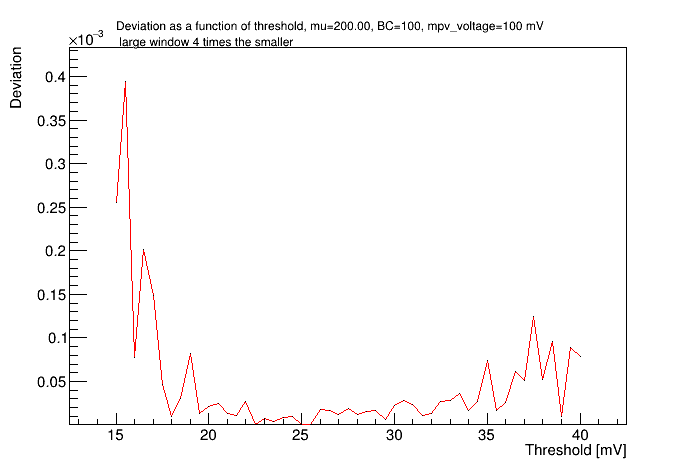

In [15]:
# Determine threshold that yields the lowest deviation 
best = find_best_threshold(total_deviation)

c = TCanvas( 'c1', 'Graph', 200, 10, 700, 500 )
#c1.SetLogy()

g = TGraph(len(threshold_array), threshold_array.astype(np.double),total_deviation.astype(np.double))
g.SetTitle( "#splitline{Deviation as a function of threshold, mu=%.2f, BC=%d, mpv_voltage=%d mV}{\n large window 4 times the smaller}"  %(mu, bunch_crossings, peak_value_step))
g.GetXaxis().SetTitle( 'Threshold [mV]' )
g.GetYaxis().SetTitle( 'Deviation' )
g.GetYaxis().SetRange(0,10);
g.SetLineColor(2)
g.Draw() 
c.Draw()

### Study the effect of the large time window
<ul>
    <li>Plot the same data but generated with different time windows

Best threshold: 23.250000
Best threshold: 23.750000
Best threshold: 23.100000
Best threshold: 23.100000


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


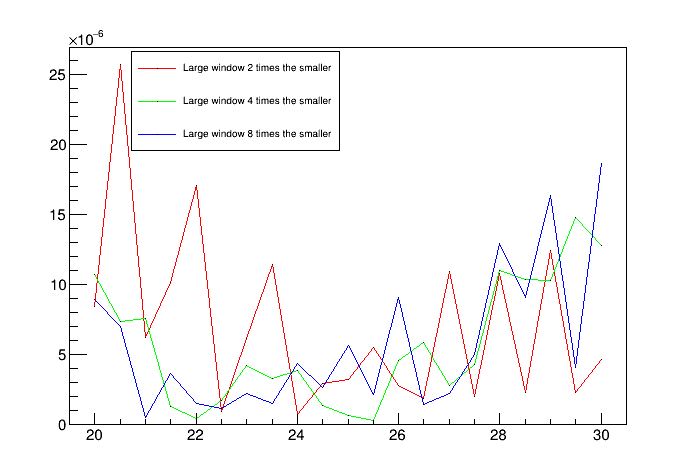

In [93]:
# Recover data 
%store -r total_deviation2 total_deviation4 total_deviation6 total_deviation8

c = TCanvas( 'c1', 'Graph', 200, 10, 700, 500 )

# Multiple graphs
g2 = TGraph(len(threshold_array), threshold_array.astype(np.double),total_deviation2.astype(np.double))
g2.SetLineColor(2)
g2.SetTitle("Large window 2 times the smaller")

g4 = TGraph(len(threshold_array), threshold_array.astype(np.double),total_deviation4.astype(np.double))
g4.SetLineColor(3)
g4.SetTitle("Large window 4 times the smaller")

g6 = TGraph(len(threshold_array), threshold_array.astype(np.double),total_deviation6.astype(np.double))
g6.SetLineColor(4)
g6.SetTitle("Large window 6 times the smaller")

g8 = TGraph(len(threshold_array), threshold_array.astype(np.double),total_deviation8.astype(np.double))
g8.SetLineColor(4)
g8.SetTitle("Large window 8 times the smaller")

mg = ROOT.TMultiGraph()
mg.Add(g2);
mg.Add(g4);
#mg.Add(g6,"");
mg.Add(g8);
mg.Draw("ALP");

c.BuildLegend()
c.Update();
c.Modified();
c.Draw()

best2 = find_best_threshold(total_deviation2)
best4 = find_best_threshold(total_deviation4)
best6 = find_best_threshold(total_deviation6)
best8 = find_best_threshold(total_deviation8)

## Higher resolution plot with error bars 
#### Finer search for the best threshold: mean values and corresponding standard deviations
Plots three graphs:
<ul>
    <li>STD values of the deviations yielded at each threshold, that is, the statistical error</li>
    <li>The mean values of the deviations centered around zero for each threshold</li>
    <li>A corrected plot of the mean values, where they are added with the corresponding standard deviations</li>
</ul>

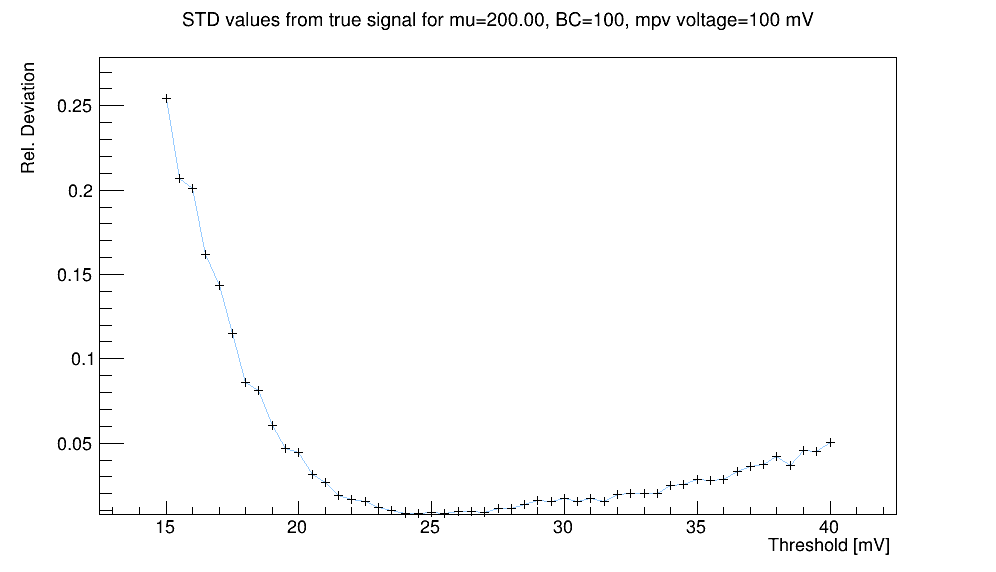

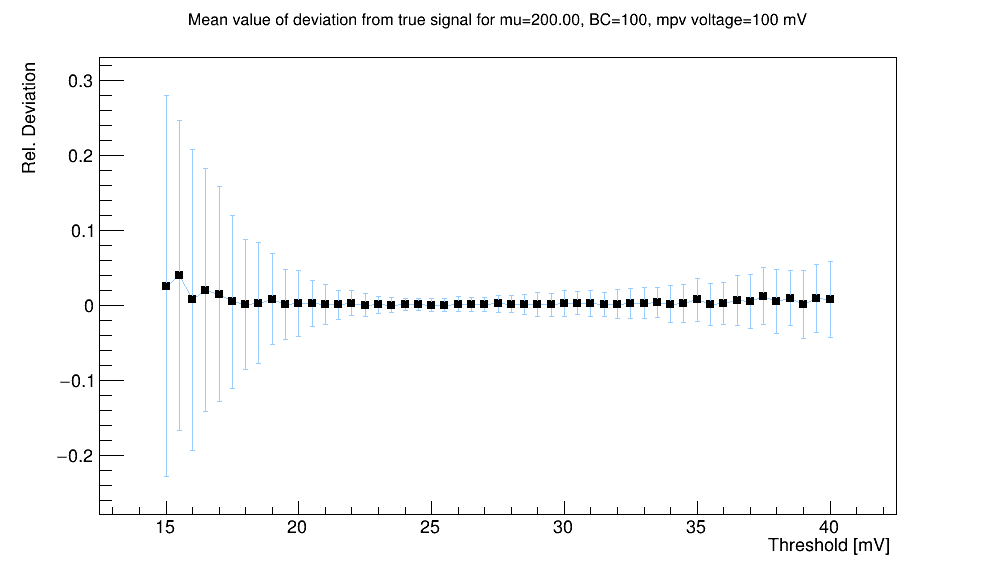

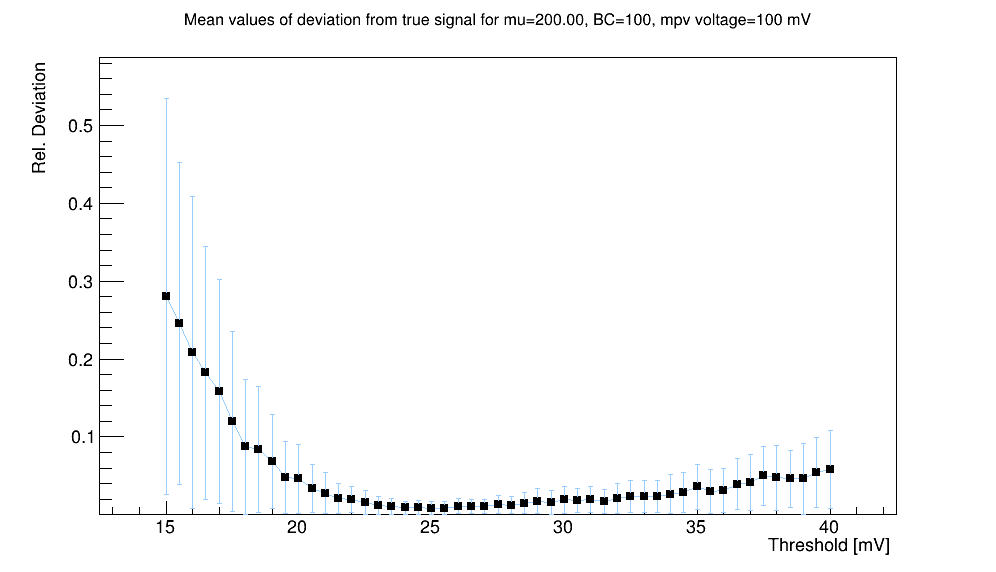

In [16]:
threshold_error = []
mean_rel = []
std_rel= []
mean_std_rel = []

#Calculate relative error for each array
for i in range (len(threshold_array)):
    threshold_error.append(0)
    #multiply by 100 to get relative error 
    std_rel.append(std_values[i]*100)
    mean_rel.append(mean_values[i]*100)
    mean_std_rel.append(mean_values_with_std[i]*100)

"""Standard deviation vs threshold plot"""

#create x,y values and corresponding errors
n = len(threshold_array);
x  = array( 'f', threshold_array )
ex = array( 'f', threshold_error)
y  = array( 'f', std_rel)
ey = array( 'f', threshold_error) 

std_graph = ROOT.TGraphErrors( n, x, y, ex, ey )
c1 = ROOT.TCanvas("std over Threshold", "Difference in counts", 1000, 600)
std_graph.SetTitle("STD values from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Rel. Deviation; Z axis title" %(mu, bunch_crossings, peak_value_step))
std_graph.SetMarkerStyle(2)
std_graph.SetLineColor(ROOT.kAzure-9)
std_graph.SetFillColor(ROOT.kAzure-14)
std_graph.Draw()
#c1.SetLogy()
c1.Draw()


"""Mean value vs threshold plot"""
y  = array( 'f', mean_rel)
ey = array( 'f', std_rel) 
deviation_graph = ROOT.TGraphErrors( n, x, y, ex, ey )
c2 = ROOT.TCanvas("mean canvas", "", 1000, 600)
deviation_graph.SetTitle("Mean value of deviation from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Rel. Deviation; Z axis title" %(mu, bunch_crossings, peak_value_step))
deviation_graph.SetMarkerStyle(21)
deviation_graph.SetLineColor(ROOT.kAzure-9)
deviation_graph.SetFillColor(ROOT.kAzure-14)
deviation_graph.Draw()
#c2.SetLogy()
c2.Draw()


"""Mean+std vs threshold plot"""
y  = array( 'f', mean_std_rel)
ey = array( 'f', std_rel) 
mean_std_graph = ROOT.TGraphErrors( n, x, y, ex, ey )
c3 = ROOT.TCanvas("mean_std", "Difference in counts", 1000, 600)
mean_std_graph.SetTitle("Mean values of deviation from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Rel. Deviation; Z axis title" %(mu, bunch_crossings, peak_value_step))
mean_std_graph.SetMarkerStyle(21)
mean_std_graph.SetLineColor(ROOT.kAzure-9)
mean_std_graph.SetFillColor(ROOT.kAzure-14)
mean_std_graph.Draw()
#c3.SetLogy()
c3.Draw()

### Multigraph for standard deviations depending on size of large time window

Warning in <TCanvas::Constructor>: Deleting canvas with same name: multigraph std


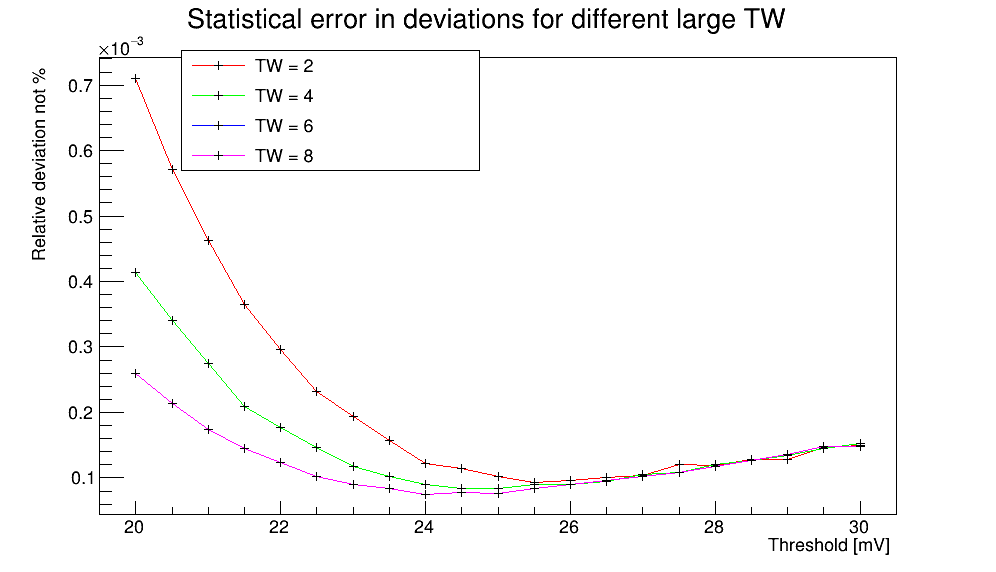

In [98]:
# Restore old variables
%store -r std_values2 std_values4 std_values6 std_values8

c1 = ROOT.TCanvas("multigraph std","f", 1000, 600)

#create x,y values and corresponding errors
n = len(threshold_array);
x  = array( 'f', threshold_array )
ex = array( 'f', threshold_error)
ey = array( 'f', threshold_error) 
y2  = array( 'f', std_values2)
y4  = array( 'f', std_values4)
y6  = array( 'f', std_values6)
y8  = array( 'f', std_values8)

g2 = ROOT.TGraphErrors(n, x, y2, ex, ey)
g2.SetTitle("TW = 2")
g2.SetMarkerStyle(2)
g2.SetLineColor(2)

g4 = ROOT.TGraphErrors(n, x, y4, ex, ey)
g4.SetTitle("TW = 4")
g4.SetMarkerStyle(2)
g4.SetLineColor(3)

g6 = ROOT.TGraphErrors(n, x, y6, ex, ey)
g6.SetTitle("TW = 6")
g6.SetMarkerStyle(2)
g6.SetLineColor(4)

g8 = ROOT.TGraphErrors(n, x, y8, ex, ey)
g8.SetTitle("TW = 8")
g8.SetMarkerStyle(2)
g8.SetLineColor(6)

mg = ROOT.TMultiGraph()
mg.Add(g2);
mg.Add(g4);
mg.Add(g6,"");
mg.Add(g8);
mg.SetTitle("Statistical error in deviations for different large TW")
mg.GetXaxis().SetTitle( 'Threshold [mV]' )
mg.GetYaxis().SetTitle( 'Relative deviation not %' )
mg.Draw("ALP");

c1.BuildLegend()
c1.Update();
c1.Modified();

#c1.SetLogy()
c1.Draw()

## Study of radiation damage on sensors
#### With time, the sensors get damaged by radiation and this is reflected on a lower SNR (from 20 to only 5). We can express this by setting lower values of the mpv of the peak voltage from 100mV to a set minimum and see how the lowest deviations and corresponding thresholds change with the worsening of the sensors

#### Plot the best threshold and lowest possible deviations for each mpv
    

In [ ]:
plt.scatter(mpv_peak_array, best_threshold_array, marker = "x", color='red')
plt.title("Best threshold as a function of sensor quality, mu=%f \n BC=%d" %(mu, bunch_crossings))
plt.xlabel("mpv Voltage [mV]")
plt.ylabel("Best threshold [mV]")
plt.show()

plt.scatter(mpv_peak_array, min_deviation_array*100, marker = "x", color='red')
plt.title("Deviation as a function of sensor quality, mu=%.f \n BC=%d" %(mu, bunch_crossings))
plt.xlabel("mpv Voltage [mV]")
plt.ylabel("Smallest deviation")
plt.show()

#### Study the radiation damage by plotting the deviations and thresholds for different mpv voltages (100mV when the sensors are new) in 3d plots


In [ ]:
"""3D scatter plot with best thresholds and minimal deviation for that threshold"""
x = mpv_peak_array
y = best_threshold_array
z = min_deviation_array*100
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y ,z)
pnt3d=ax.scatter(x,y,z,c=z)
ax.set_title('Best threshold and smallest deviation for each mpv')
ax.set_zlabel('Smallest Relative Deviation per mpv')
ax.set_xlabel('Best threshold [mV]')
ax.set_ylabel('Mpv voltage[mV]')
# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([1, 0.2, 0.05, 0.6]) 
c = plt.colorbar(pnt3d, cax = cbaxes) 
plt.show()


"""3D plot of deviation as a function of mpv and threshold"""
x = mpv_peak_array
y = threshold_array
z = np.array(mpv_and_deviation)*100

xv, yv = np.meshgrid(x, y)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plot3d=ax.plot_surface(xv,yv,z,cmap='afmhot',)
ax.set_title('Effects of radiation damage on deviation from true signal')
ax.set_zlabel('Relative Deviation')
ax.set_xlabel('Most probable peak voltage [mV]')
ax.set_ylabel('Threshold [mV]')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
cbaxes = fig.add_axes([0.92, 0.2, 0.05, 0.6]) 
cb = plt.colorbar(plot3d, cax = cbaxes)  
plt.show()

#### Contour plot to find the "valley" of best thresholds with the worsening of the sensors


In [ ]:
fig = plt.figure(figsize=(5,5))
plt.contour(x, y, z, 30, cmap='RdGy');
plt.title("Thresholds and deviations for each mpv")
plt.xlabel("Mpv Voltage [mV]")
plt.ylabel("Threshold [mV]")
plt.colorbar();

In [ ]:
x = mpv_peak_array
y = threshold_array
z = np.array(mpv_and_deviation)*100

xv, yv = np.meshgrid(x, y)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plot3d=ax.plot_surface(xv,yv,z,cmap='afmhot',)
ax.set_title('Effects of radiation damage on deviation from true signal')
ax.set_zlabel('Deviation')
ax.set_xlabel('Most probable peak voltage [mV]')
ax.set_ylabel('Threshold [mV]')
# Customize the z axis.
#ax.set_zlim(0, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([0.9, 0.2, 0.05, 0.6]) 
cb = plt.colorbar(plot3d, cax = cbaxes)  
plt.show()

snr = 20 in the beginning

snr = 5 later 

large time window multiple of 3.125

todo later: check non-linear approximation of nr of particles vs mu 

